### Import Libraries

In [13]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix,classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale,StandardScaler
from keras_preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Model
import tensorflow as tf

from warnings import filterwarnings
filterwarnings("ignore")

### Load the data

In [14]:
train_data=pd.read_csv('olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')

train_tweets = train_data[['tweet']] #Extract tweets
train_task_a_labels= train_data[['subtask_a']] #Extract subtsak_a labels
train_task_b_labels= train_data[['subtask_b']] #Extract subtsak_b labels
train_task_c_labels= train_data[['subtask_c']] #Extract subtsak_c labels

train_task_a_labels.columns.values[0] = 'class_a' #Rename class attribute
train_task_b_labels.columns.values[0] = 'class_b' #Rename class attribute
train_task_c_labels.columns.values[0] = 'class_c' #Rename class attribute

print(train_data)

          id                                              tweet subtask_a  \
0      86426  @USER She should ask a few native Americans wh...       OFF   
1      90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2      16820  Amazon is investigating Chinese employees who ...       NOT   
3      62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4      43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   
...      ...                                                ...       ...   
13235  95338  @USER Sometimes I get strong vibes from people...       OFF   
13236  67210  Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...       NOT   
13237  82921  @USER And why report this garbage.  We don't g...       OFF   
13238  27429                                        @USER Pussy       OFF   
13239  46552  #Spanishrevenge vs. #justice #HumanRights and ...       NOT   

      subtask_b subtask_c  
0           UNT       NaN  
1           TIN    

### Text preprocessing

In [15]:
def clean_tweets(df):
    
    punctuations = string.punctuation
    
    df.loc[:, 'tweet'] = df.tweet.str.replace('@USER', '') #Remove mentions (@USER)
    df.loc[:, 'tweet'] = df.tweet.str.replace('URL', '') #Remove URLs
    df.loc[:, 'tweet'] = df.tweet.str.replace('&amp', 'and') #Replace ampersand (&) with and
    df.loc[:, 'tweet'] = df.tweet.str.replace('&lt','') #Remove &lt
    df.loc[:, 'tweet'] = df.tweet.str.replace('&gt','') #Remove &gt
    df.loc[:, 'tweet'] = df.tweet.str.replace('\d+','') #Remove numbers
    df.loc[:, 'tweet'] = df.tweet.str.lower() #Lowercase

    #Remove punctuations
    for punctuation in punctuations:
        df.loc[:, 'tweet'] = df.tweet.str.replace(punctuation, '')

    df.loc[:, 'tweet'] = df.astype(str).apply(
        lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')
    )
    #Remove emojis
    df.loc[:, 'tweet'] = df.tweet.str.strip() #Trim leading and trailing whitespaces

In [16]:
clean_tweets(train_tweets)

In [17]:
train_task_a_data = train_tweets.join(train_task_a_labels)

train_task_b_data = train_tweets.join(train_task_b_labels)
train_task_b_data = train_task_b_data.dropna() #Drop records with missing values

train_task_c_data = train_tweets.join(train_task_c_labels)
train_task_c_data = train_task_c_data.dropna() #Drop records with missing values

#Apply quotes to cleaned tweets
train_task_a_data.update(train_task_a_data[['tweet']].applymap('\'{}\''.format))
train_task_b_data.update(train_task_b_data[['tweet']].applymap('\'{}\''.format))
train_task_c_data.update(train_task_c_data[['tweet']].applymap('\'{}\''.format))

In [18]:
train_task_a_data.head()

,tweet,class_a
0,'she should ask a few native americans what th...,OFF
1,'go home youre drunk maga trump',OFF
2,'amazon is investigating chinese employees who...,NOT
3,'someone shouldvetaken this piece of shit to a...,OFF
4,'obama wanted liberals and illegals to move in...,NOT


In [19]:
#Read tweets from test sets
test_tweet_a=pd.read_csv('testset-levela.tsv', delimiter='\t', encoding='utf-8')
test_tweet_b=pd.read_csv('testset-levelb.tsv', delimiter='\t', encoding='utf-8')
test_tweet_c=pd.read_csv('testset-levelc.tsv', delimiter='\t', encoding='utf-8')

#Read tweet labels
test_label_a=pd.read_csv('labels-levela.csv', encoding='utf-8', 
                         index_col=False, names=['id', 'class_a'])
test_label_b=pd.read_csv('labels-levelb.csv', encoding='utf-8', 
                         index_col=False, names=['id', 'class_b'])
test_label_c=pd.read_csv('labels-levelc.csv', encoding='utf-8', 
                         index_col=False, names=['id', 'class_c'])

#Merge tweets with labels by id
test_tweet_a = test_tweet_a.merge(test_label_a, on='id')
test_tweet_b = test_tweet_b.merge(test_label_b, on='id')
test_tweet_c = test_tweet_c.merge(test_label_c, on='id')

#Drop id column
test_tweet_a = test_tweet_a.drop(columns='id')
test_tweet_b = test_tweet_b.drop(columns='id')
test_tweet_c = test_tweet_c.drop(columns='id')

#Clean tweets in test sets
clean_tweets(test_tweet_a)
clean_tweets(test_tweet_b)
clean_tweets(test_tweet_c)

#Apply quotes to cleaned tweets
test_tweet_a.update(test_tweet_a[['tweet']].applymap('\'{}\''.format))
test_tweet_b.update(test_tweet_b[['tweet']].applymap('\'{}\''.format))
test_tweet_c.update(test_tweet_c[['tweet']].applymap('\'{}\''.format))

In [20]:
test_tweet_a.head()

,tweet,class_a
0,'whoisq wherestheserver dumpnike declasfisa de...,OFF
1,'constitutionday is revered by conservatives h...,NOT
2,'foxnews nra maga potus trump ndamendment rnc ...,NOT
3,'watching boomer getting the news that she is ...,NOT
4,'nopasaran unity demo to oppose the farright i...,OFF


In [21]:
def count_classes(df,task):
    sns.countplot(df[task])
    plt.title("Classes in dataset")

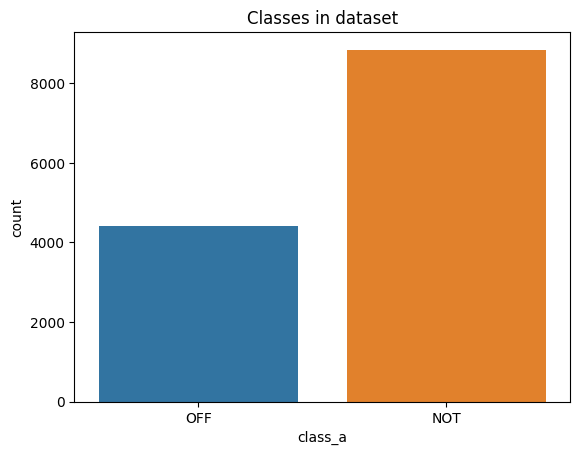

In [22]:
count_classes(train_task_a_data,"class_a")

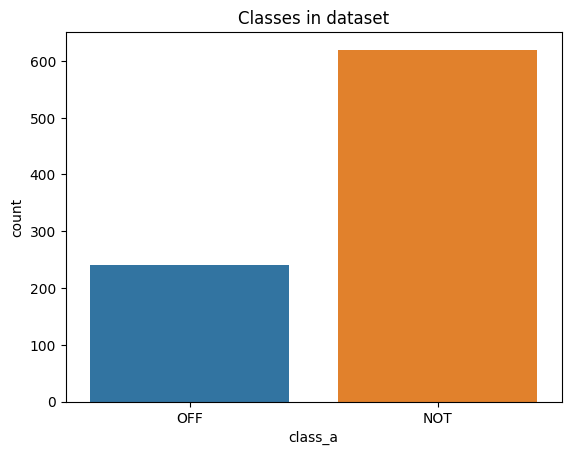

In [23]:
count_classes(test_tweet_a,"class_a")

### Bidirectional LSTM

#### TASK A

In [24]:
# Creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_task_a_data["class_a_code"] = encoder.fit_transform(train_task_a_data["class_a"])
test_tweet_a["class_a_code"] = encoder.fit_transform(test_tweet_a["class_a"])

In [25]:
#Create tuple pair for class and class code
train_task_a_data['class-tuple'] = train_task_a_data[['class_a', 'class_a_code']].apply(tuple, axis=1)
class_a = train_task_a_data['class-tuple'].unique()
class_a

array([('OFF', 1), ('NOT', 0)], dtype=object)

In [27]:
# Label the Data

train_tweets = train_task_a_data['tweet']
train_labels = train_task_a_data['class_a_code']

X_test = test_tweet_a['tweet']
y_test = test_tweet_a['class_a_code']


print("Shape of train_tweet is {} and shape of train_label is {}".format(train_tweets.shape, train_labels.shape))
print("Shape of test_tweet is {} and shape of test_label is {}".format(X_test.shape, y_test.shape))

Shape of train_tweet is (13240,) and shape of train_label is (13240,)
Shape of test_tweet is (860,) and shape of test_label is (860,)


In [28]:
X_train,X_val,y_train,y_val = train_test_split(train_tweets,train_labels,test_size=0.30,random_state=42)


print("Shape of test_tweets is {} and shape of test_labels is {}".format(X_test.shape, y_test.shape))

Shape of test_tweets is (860,) and shape of test_labels is (860,)


In [29]:
# TOKENIZER
max_features = 10000
embedding_dim = 128
max_len=500

tokenizer=Tokenizer(num_words=max_features,oov_token='</OOV>')
tokenizer.fit_on_texts(X_train.values)
dic=tokenizer.word_index
#print(dic)

In [30]:
# TRAIN
X_train_seq = tokenizer.texts_to_sequences(X_train.values)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

print("train data tensor:" ,X_train_pad.shape)

train data tensor: (9268, 500)


In [31]:
# VAL
X_val_seq = tokenizer.texts_to_sequences(X_val.values)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

print("test data tensor:" ,X_val_pad.shape)

test data tensor: (3972, 500)


In [32]:
# TEST
X_test_seq = tokenizer.texts_to_sequences(X_test.values)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print("test data tensor:" ,X_test_pad.shape)

test data tensor: (860, 500)


In [33]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional

In [34]:
model= Sequential()
model.add(Embedding(max_features,embedding_dim,input_length=max_len))
model.add(Bidirectional(LSTM(128, dropout=0.3)))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,576,193
Trainable params: 1,576,193
Non-trainable params: 0
______________________________________________

In [36]:
METRICS = [tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")]


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)

In [37]:
epochs = 10

# Fit the model using the train and test datasets.
history = model.fit(X_train_pad,y_train,validation_data=(X_val_pad,y_val), epochs=epochs)

Epoch 1/10
290/290 [==============================] - 270s 917ms/step - loss: 0.6074 - binary_accuracy: 0.6889 - precision: 0.6415 - recall: 0.1360 - val_loss: 0.5436 - val_binary_accuracy: 0.7339 - val_precision: 0.7413 - val_recall: 0.3181
Epoch 2/10
290/290 [==============================] - 320s 1s/step - loss: 0.4347 - binary_accuracy: 0.8046 - precision: 0.7643 - recall: 0.5921 - val_loss: 0.5482 - val_binary_accuracy: 0.7399 - val_precision: 0.6451 - val_recall: 0.5004
Epoch 3/10
290/290 [==============================] - 264s 911ms/step - loss: 0.2925 - binary_accuracy: 0.8828 - precision: 0.8504 - recall: 0.7838 - val_loss: 0.6499 - val_binary_accuracy: 0.7075 - val_precision: 0.5674 - val_recall: 0.5401
Epoch 4/10
290/290 [==============================] - 287s 988ms/step - loss: 0.1974 - binary_accuracy: 0.9277 - precision: 0.9064 - recall: 0.8715 - val_loss: 0.7766 - val_binary_accuracy: 0.7072 - val_precision: 0.5659 - val_recall: 0.5476
Epoch 5/10
290/290 [===============

In [38]:
scores = model.evaluate(X_test_pad, y_test, return_dict=True)

print(scores)

27/27 [==============================] - 7s 253ms/step - loss: 1.3974 - binary_accuracy: 0.7372 - precision: 0.5263 - recall: 0.5833
{'loss': 1.3973636627197266, 'binary_accuracy': 0.7372093200683594, 'precision': 0.5263158082962036, 'recall': 0.5833333134651184}


In [39]:
y_pred = model.predict(X_test_pad)

27/27 [==============================] - 7s 209ms/step


In [40]:
for i in range(len(y_pred)):
    if(y_pred[i] > 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] =0 

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       620
           1       0.53      0.58      0.55       240

    accuracy                           0.74       860
   macro avg       0.68      0.69      0.68       860
weighted avg       0.75      0.74      0.74       860



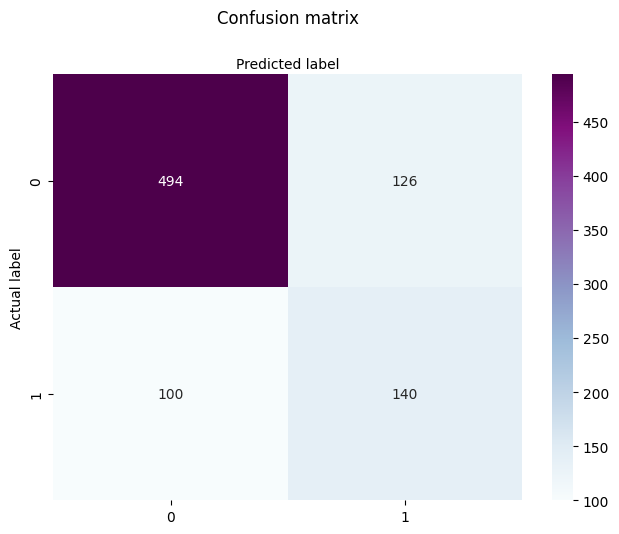

In [42]:
def plot_conf_matrix(test_label,predicted_label):
    cm = confusion_matrix(test_label,predicted_label)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label');

plot_conf_matrix(y_test,y_pred)

### Task B

In [43]:
# Our predicted OFF - offensive data
df_pred = pd.DataFrame(data=y_pred,columns=["predicted"])
predicted_data = pd.concat([test_tweet_a, df_pred],axis=1)
off_data = predicted_data[predicted_data.predicted ==1]
off_data.head()

,tweet,class_a,class_a_code,predicted
0,'whoisq wherestheserver dumpnike declasfisa de...,OFF,1,1.0
5,'what the fuck did he do this time',OFF,1,1.0
6,'rap is a form of art used to express yourself...,NOT,0,1.0
14,'nigga ware da hits at',OFF,1,1.0
15,'stopkavanaugh he is liar like the rest of the...,OFF,1,1.0


In [44]:
# prepare test data for task B
test_b = off_data.merge(test_tweet_b,on="tweet")
test_b = test_b[["tweet","class_b"]]
print(test_b.shape)
test_b.head()

(145, 2)


,tweet,class_b
0,'whoisq wherestheserver dumpnike declasfisa de...,TIN
1,'what the fuck did he do this time',TIN
2,'nigga ware da hits at',UNT
3,'stopkavanaugh he is liar like the rest of the...,TIN
4,'all familyfriends do not tell me bad shit t...,TIN


In [45]:
# prepare train data for task B
# dataframe task_a and task_b merged
df_a_b = pd.concat([train_task_a_data,train_task_b_data],axis=1)
df_a_b = df_a_b[df_a_b.class_a =="OFF"]
df_a_b = df_a_b[["tweet","class_b"]]
df_a_b= df_a_b.T.drop_duplicates().T
train_b = df_a_b.copy()
print("Data shape without undersampling:",train_b.shape)
train_b.head()

train_b_unt = train_b[train_b["class_b"] == "UNT"]
train_b_tin = train_b[train_b["class_b"] == "TIN"]
train_b_tin = train_b_tin.sample(1000)
train_b_new = pd.concat([train_b_unt,train_b_tin])
print("Data shape with undersampling",train_b_new.shape)
train_b_new.head()

Data shape without undersampling: (4400, 2)
Data shape with undersampling (1524, 2)


,tweet,class_b
0,'she should ask a few native americans what th...,UNT
3,'someone shouldvetaken this piece of shit to a...,UNT
6,'oh noes tough shit',UNT
29,'she to whom are you referring to hillary y...,UNT
111,'its literally a narrative that is on par with...,UNT


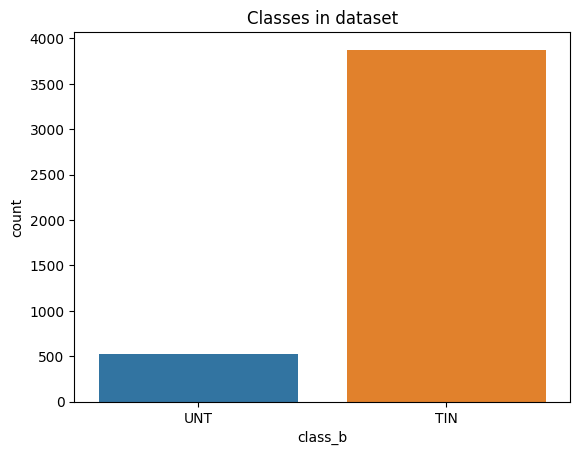

In [46]:
# Before under-sampling the train data<
count_classes(train_b,"class_b")

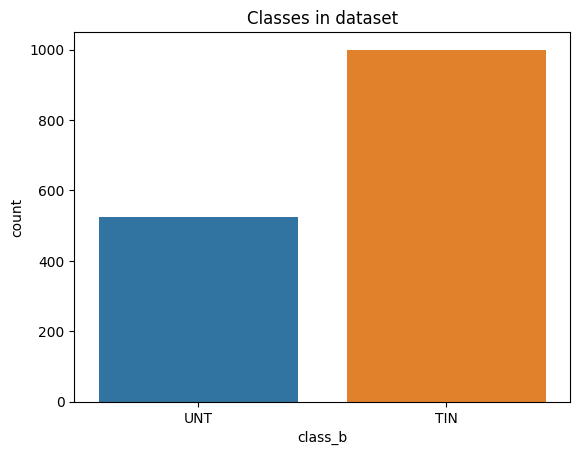

In [47]:
# After under-sampling the train data
count_classes(train_b_new,"class_b")

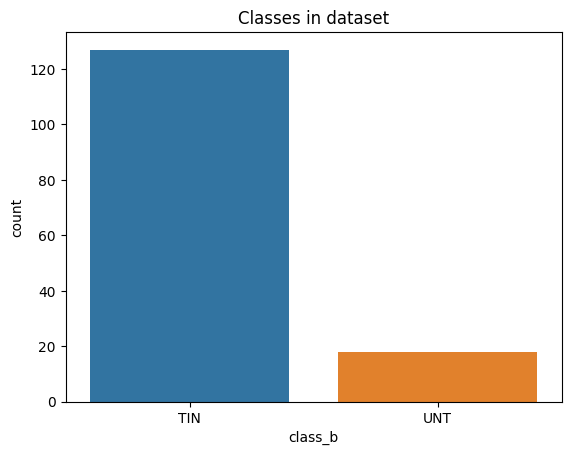

In [48]:
# Plot test data 
count_classes(test_b,"class_b")

In [49]:
#creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_b["class_b_code"] = encoder.fit_transform(train_b["class_b"])
train_b_new["class_b_code"] = encoder.fit_transform(train_b_new["class_b"])
test_b["class_b_code"] = encoder.fit_transform(test_b["class_b"])

In [50]:
#Create tuple pair for class and class code
train_b['class-tuple'] = train_b[['class_b', 'class_b_code']].apply(tuple, axis=1)
class_b = train_b['class-tuple'].unique()
class_b

array([('UNT', 1), ('TIN', 0)], dtype=object)

In [51]:
# Set the labels and train-test split

train_tweets = train_b_new['tweet']
train_labels = train_b_new['class_b_code']

X_test = test_b['tweet']
y_test = test_b['class_b_code']

X_train,X_val,y_train,y_val = train_test_split(train_tweets,train_labels,test_size=0.30,random_state=42)

print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

print("Shape of test_tweets is {} and shape of test_labels is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (1066,) and shape of y_train is (1066,)
Shape of X_test is (145,) and shape of y_test is (145,)
Shape of test_tweets is (145,) and shape of test_labels is (145,)


In [52]:
# TRAIN
X_train_seq = tokenizer.texts_to_sequences(X_train.values)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

print("train data tensor:" ,X_train_pad.shape)

train data tensor: (1066, 500)


In [53]:
# VAL
X_val_seq = tokenizer.texts_to_sequences(X_val.values)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

print("test data tensor:" ,X_val_pad.shape)

test data tensor: (458, 500)


In [54]:
# TEST
X_test_seq = tokenizer.texts_to_sequences(X_test.values)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print("test data tensor:" ,X_test_pad.shape)

test data tensor: (145, 500)


In [55]:
epochs = 10

# Fit the model using the train and test datasets.
history = model.fit(X_train_pad,y_train,validation_data=(X_val_pad,y_val), epochs=epochs)

Epoch 1/10
34/34 [==============================] - 37s 1s/step - loss: 1.0963 - binary_accuracy: 0.6182 - precision: 0.4068 - recall: 0.1925 - val_loss: 0.6341 - val_binary_accuracy: 0.6725 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
34/34 [==============================] - 30s 892ms/step - loss: 0.6542 - binary_accuracy: 0.6492 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6413 - val_binary_accuracy: 0.6725 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
34/34 [==============================] - 30s 892ms/step - loss: 0.6239 - binary_accuracy: 0.6492 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6329 - val_binary_accuracy: 0.6725 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
34/34 [==============================] - 30s 884ms/step - loss: 0.6042 - binary_accuracy: 0.6492 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6460 - val_binary_accuracy: 0.6725 - val_precision: 0.0000e+00 - val_recall: 0.

In [56]:
scores = model.evaluate(X_test_pad, y_test, return_dict=True)

print(scores)

5/5 [==============================] - 1s 206ms/step - loss: 0.3286 - binary_accuracy: 0.7517 - precision: 0.2857 - recall: 0.6667
{'loss': 0.32858413457870483, 'binary_accuracy': 0.751724123954773, 'precision': 0.2857142984867096, 'recall': 0.6666666865348816}


In [57]:
y_pred = model.predict(X_test_pad)

5/5 [==============================] - 1s 184ms/step


In [58]:
for i in range(len(y_pred)):
    if(y_pred[i] > 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] =0 

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       127
           1       0.29      0.67      0.40        18

    accuracy                           0.75       145
   macro avg       0.61      0.72      0.62       145
weighted avg       0.86      0.75      0.79       145



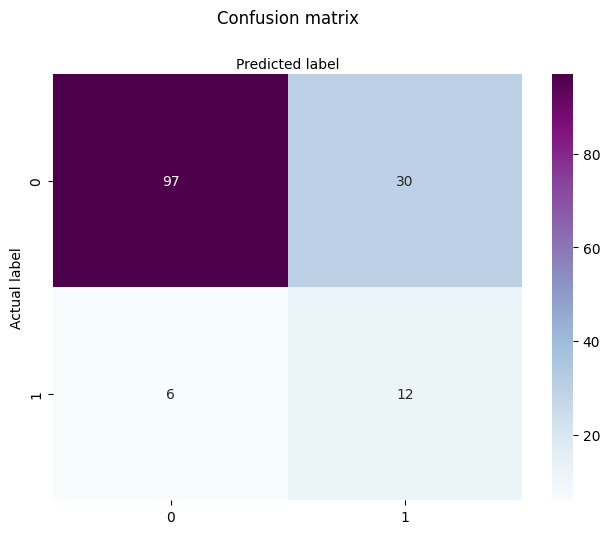

In [60]:
plot_conf_matrix(y_test,y_pred)

### Task C

In [61]:
# Our predicted TIN - Targeted Insult data
df_pred = pd.DataFrame(data=y_pred,columns=["predicted"])
predicted_data = pd.concat([test_tweet_b, df_pred],axis=1)
tin_data = predicted_data[predicted_data.predicted ==0]
print(tin_data.shape)
tin_data.head()

(103, 3)


,tweet,class_b,predicted
0,'whoisq wherestheserver dumpnike declasfisa de...,TIN,0.0
3,'do you get the feeling he is kissing behind ...,TIN,0.0
4,'nigga ware da hits at',UNT,0.0
6,'put delauro in a police lineup identifying th...,TIN,0.0
7,'all familyfriends do not tell me bad shit t...,TIN,0.0


In [62]:
# prepare test data for task C
test_c = tin_data.merge(test_tweet_c,on="tweet")
test_c = test_c[["tweet","class_c"]]
print(test_c.shape)
test_c.head()

(94, 2)


,tweet,class_c
0,'whoisq wherestheserver dumpnike declasfisa de...,OTH
1,'do you get the feeling he is kissing behind ...,OTH
2,'put delauro in a police lineup identifying th...,IND
3,'all familyfriends do not tell me bad shit t...,GRP
4,'christineblaseyford is your kavanaugh accuser...,IND


In [63]:
# prepare train data for task C
# dataframe task_b and task_c merged
df_b_c = pd.concat([train_task_b_data,train_task_c_data],axis=1)
df_b_c = df_b_c[df_b_c.class_b =="TIN"]
df_b_c = df_b_c[["tweet","class_c"]]
df_b_c= df_b_c.T.drop_duplicates().T
train_c = df_b_c.copy()
print("Data shape without over and undersampling:",train_c.shape)
train_c.head()


train_c_ind = train_c[train_c["class_c"] == "IND"]
train_c_oth = train_c[train_c["class_c"] == "OTH"]
train_c_grp = train_c[train_c["class_c"] == "GRP"]
train_c_ind = train_c_ind.sample(1500)
train_c_oth = train_c_oth.sample(1000, replace=True)
train_c_grp = train_c_grp.sample(1000)
train_c_new = pd.concat([train_c_ind,train_c_oth,train_c_grp])
print("Data shape with undersampling",train_c_new.shape)
train_c_new.head()

Data shape without over and undersampling: (3876, 2)
Data shape with undersampling (3500, 2)


,tweet,class_c
7131,'now you touched visamatas raw nerve by saying...,IND
13052,'at an antifa riot and screaming at white people',IND
3565,'truthfeed news just in fbi deals yet anothe...,IND
8632,'hes not an opportunistic liar nor have you pr...,IND
5540,'surely he didnt do anything to damage veteren...,IND


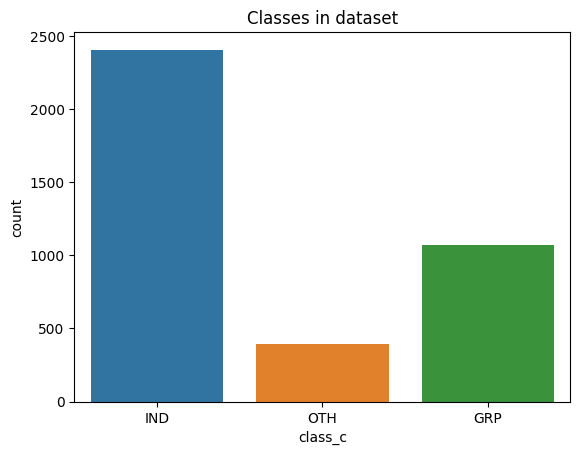

In [64]:
# Plot the train data without over and undersapmling the classes

count_classes(train_c,"class_c")

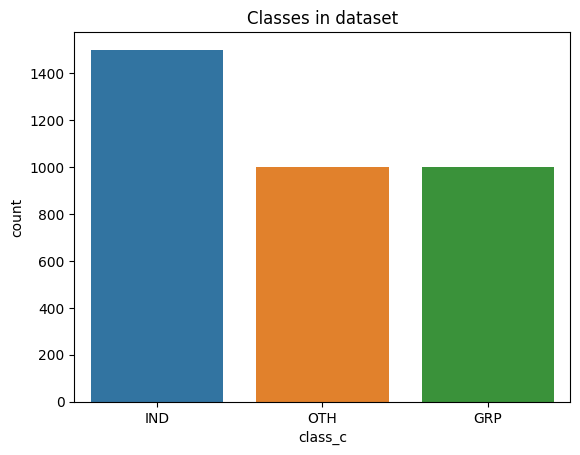

In [65]:
# Plot the train data with over and undersapmling the classes

count_classes(train_c_new,"class_c")

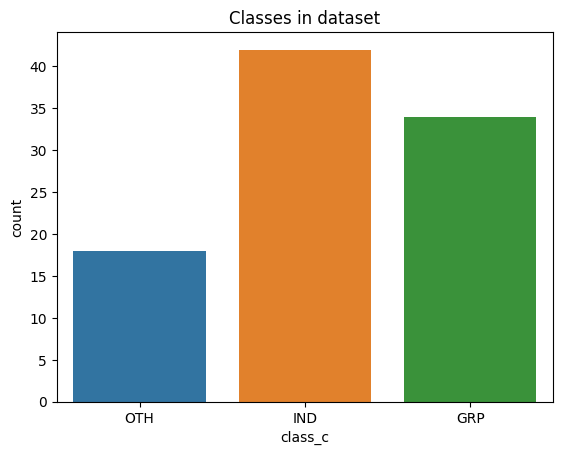

In [66]:
# Plot test data 
count_classes(test_c,"class_c")

In [67]:
#creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_c["class_c_code"] = encoder.fit_transform(train_c["class_c"])
train_c_new["class_c_code"] = encoder.fit_transform(train_c_new["class_c"])
test_c["class_c_code"] = encoder.fit_transform(test_c["class_c"])

In [68]:
#Create tuple pair for class and class code
train_c['class-tuple'] = train_c[['class_c', 'class_c_code']].apply(tuple, axis=1)
class_c = train_c['class-tuple'].unique()
class_c

array([('IND', 1), ('OTH', 2), ('GRP', 0)], dtype=object)

In [69]:
# Set the labels and train-test split

train_tweets = train_c_new['tweet']
train_labels = train_c_new['class_c_code']

X_test = test_c['tweet']
y_test = test_c['class_c_code']

X_train,X_val,y_train,y_val = train_test_split(train_tweets,train_labels,test_size=0.30,random_state=42)

print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_val.shape, y_val.shape))

print("Shape of test_tweets is {} and shape of test_labels is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (2450,) and shape of y_train is (2450,)
Shape of X_test is (1050,) and shape of y_test is (1050,)
Shape of test_tweets is (94,) and shape of test_labels is (94,)


In [70]:
# TRAIN
X_train_seq = tokenizer.texts_to_sequences(X_train.values)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

print("train data tensor:" ,X_train_pad.shape)

train data tensor: (2450, 500)


In [71]:
# VAL
X_val_seq = tokenizer.texts_to_sequences(X_val.values)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

print("test data tensor:" ,X_val_pad.shape)

test data tensor: (1050, 500)


In [72]:
# TEST
X_test_seq = tokenizer.texts_to_sequences(X_test.values)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print("test data tensor:" ,X_test_pad.shape)

test data tensor: (94, 500)


In [73]:
model= Sequential()
model.add(Embedding(max_features,embedding_dim,input_length=max_len))
model.add(Bidirectional(LSTM(128, dropout=0.3)))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [74]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")]


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)

In [75]:
epochs = 10

# Fit the model using the train and test datasets.
history = model.fit(X_train_pad,y_train,validation_data=(X_val_pad,y_val), epochs=epochs)

Epoch 1/10
77/77 [==============================] - 79s 888ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - precision: 0.7108 - recall: 0.9977 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_precision: 0.7219 - val_recall: 1.0000
Epoch 2/10
77/77 [==============================] - 68s 879ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - precision: 0.7922 - recall: 0.7486 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_precision: 0.8364 - val_recall: 0.6069
Epoch 3/10
77/77 [==============================] - 67s 871ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - precision: 0.9255 - recall: 0.0499 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
77/77 [==============================] - 66s 862ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - precision: 0.7810 - recall: 0.8536 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_pre

In [78]:
scores = model.evaluate(X_test_pad, y_test, return_dict=True)

print(scores)

3/3 [==============================] - 1s 180ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - precision: 0.6232 - recall: 0.7167
{'loss': 0.0, 'categorical_accuracy': 1.0, 'precision': 0.6231883764266968, 'recall': 0.7166666388511658}


In [79]:
y_pred = model.predict(X_test_pad)

3/3 [==============================] - 0s 146ms/step


In [80]:
y_pred = y_pred.astype("int64")

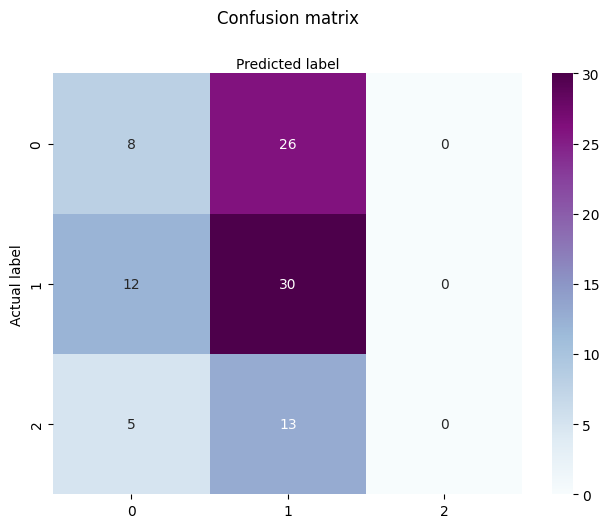

In [81]:
plot_conf_matrix(y_test,y_pred)

In [82]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.32      0.24      0.27        34
           1       0.43      0.71      0.54        42
           2       0.00      0.00      0.00        18

    accuracy                           0.40        94
   macro avg       0.25      0.32      0.27        94
weighted avg       0.31      0.40      0.34        94

